<a href="https://colab.research.google.com/github/AndreaZoccatelli/light_permanova/blob/main/fashion_mnist_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PERMANOVA test on images

**Dataset**: [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist)

**Model**: [ResNet18](https://arxiv.org/abs/1512.03385)

**Runtime**: T4

**Steps**:
1. Model is trained on the dataset deprived by the t-shirt class.
2. The distribution of the image embeddings of train and test set are compared with the ones of the t-shirt test set.
3. Train set is modified with an adversarial attack.
4. The embeddings distribution of the modified training test are compared with the original ones.


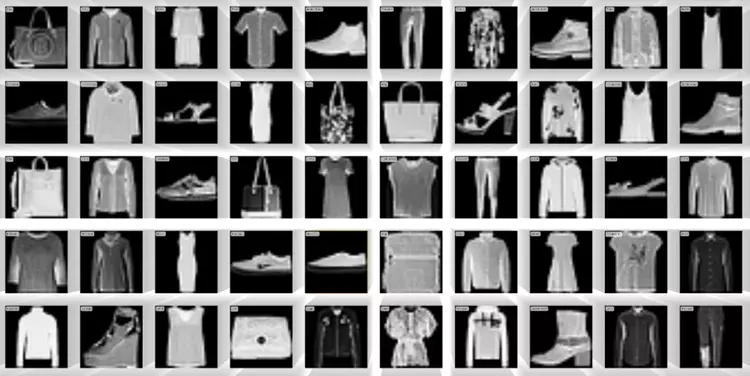

## Setup

In [1]:
!git clone https://github.com/AndreaZoccatelli/light_permanova
!pip install adversarial-robustness-toolbox

Cloning into 'light_permanova'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 12 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (12/12), 259.92 KiB | 12.38 MiB/s, done.
Resolving deltas: 100% (2/2), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.7 MB/s eta 0:00:00


In [2]:
import sys



sys.path.append("/content/light_permanova/permanova/permanova_torch")


from lightpermanova import LightPermAnova, PermAnovaSampler

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.models import resnet18
from torchvision.transforms import ToTensor
import torch.utils.data as data
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod
from tqdm import tqdm
import time
import numpy as np

In [4]:
class ResNetFashionMnist(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.model = resnet18(num_classes=9)
        self.model.conv1 = nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )

    def forward(self, x):
        return self.model(x)

In [5]:
def predict(dataset, model, device):
    test_loader = data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    test_images, _ = next(iter(test_loader))

    test_images = test_images.to(device)

    with torch.no_grad():
        predictions = model(test_images)

    return predictions

## Dataset

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

training_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

test_data_tshirt = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:13<00:00, 2012924.93it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 169858.23it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
no_tshirt_train = torch.where(training_data.targets != 0)
tshirt_train = torch.where(training_data.targets == 0)

training_data.targets = training_data.targets[no_tshirt_train[0]]
training_data.data = training_data.data[no_tshirt_train[0], :]

no_tshirt_test = torch.where(test_data.targets != 0)
tshirt_test = torch.where(test_data.targets == 0)

test_data.targets = test_data.targets[no_tshirt_test[0]]
test_data.data = test_data.data[no_tshirt_test[0], :]

training_data.targets -= 1
test_data.targets -= 1

In [ ]:
test_data_tshirt.targets = test_data_tshirt.targets[tshirt_test[0]]
test_data_tshirt.data = test_data_tshirt.data[tshirt_test[0], :]

## Model Training + Save

In [ ]:
model = ResNetFashionMnist().to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [ ]:
n_epochs = 30
loader = data.DataLoader(training_data, shuffle=True, batch_size=128)

# Training loop
model.train()
for epoch in tqdm(range(n_epochs)):
    model.train()
    loss = 0
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss}")

In [ ]:
torch.save(model.state_dict(), "/content/model_state.pth")

## Load Trained Model

In [38]:
# Convert test data to TensorDataset
model = ResNetFashionMnist().to(device)
model.load_state_dict(torch.load("/content/model_state.pth", map_location=device))

<All keys matched successfully>

In [40]:
predicted_classes = predict(test_data, model, device)
_, predicted_classes = torch.max(predicted_classes, 1)
acc = (
    torch.sum(predicted_classes.to("cpu") == test_data.targets)
    / test_data.targets.shape[0]
)
print(f"Accuracy Score: {round(acc.item(),5)}")

Accuracy Score: 0.93133


In [72]:
# Remove the output layer to obtain the embeddings
embedder = torch.nn.Sequential(*(list(model.model.children())[:-1]))
embedder = embedder.to(device)

In [18]:
# Embeddings of training dataset
train_emb = predict(training_data, embedder, device=device)
train_emb = train_emb.view(train_emb.shape[0], -1)

# Embeddings of test dataset
test_emb = predict(test_data, embedder, device=device)
test_emb = test_emb.view(test_emb.shape[0], -1)

# Embeddings of t-shirts test dataset
tshirt_emb = predict(test_data_tshirt, embedder, device=device)
tshirt_emb = tshirt_emb.view(tshirt_emb.shape[0], -1)

## Comparison with PERMANOVA

Comparison between train set and test set embeddings: the null hypothesis (samples are equal) is not rejected.

In [19]:
# To speed up the comparison train_emb is sub-sampled
sampler = PermAnovaSampler(train_emb)
train_emb_sampled = sampler.get_representative_sample(tot_permutations=100)

100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


In [25]:
permanova = LightPermAnova(train_emb_sampled, compress=False)
pvalue = permanova.run_simulation(test_emb, tot_permutations=1000)
print(f"p-value: {round(pvalue.item(),5)}")

100%|██████████| 1000/1000 [05:58<00:00,  2.79it/s]


p-value: 0.97702


Comparison between train/test set and t-shirts test set embeddings: the null hypothesis is rejected.

In [26]:
permanova = LightPermAnova(test_emb, compress=False)
pvalue = permanova.run_simulation(tshirt_emb, tot_permutations=1000)
print(f"p-value: {round(pvalue.item(),5)}")

100%|██████████| 1000/1000 [01:15<00:00, 13.17it/s]


p-value: 0.02697


In [24]:
permanova = LightPermAnova(train_emb_sampled, compress=False)
pvalue = permanova.run_simulation(tshirt_emb, tot_permutations=1000)
print(f"p-value: {round(pvalue.item(),5)}")

100%|██████████| 1000/1000 [03:46<00:00,  4.41it/s]


p-value: 0.01998


## Adversarial Attack - Training

In [63]:
criterion = nn.CrossEntropyLoss()

classifier = PyTorchClassifier(
    model=model,
    loss=criterion,
    input_shape=(1, 28, 28),
    nb_classes=9,
    device_type=device,
)

In [64]:
x_train = training_data.data.unsqueeze(1)
x_train = x_train.view(-1, 1, 28, 28)
x_train = np.array(x_train) / 255
x_train = np.float32(x_train)

In [65]:
fgsm_attack = FastGradientMethod(estimator=classifier, eps=0.05)

start = time.time()
x_train_adv = fgsm_attack.generate(x=x_train)
print("Time for attack (in seconds): {}".format(time.time() - start))

Time for attack (in seconds): 27.517816305160522


In [66]:
with open("/content/x_train_adv.npy", "wb") as file:
    np.save(file, x_train_adv)

## Adversarial Attack - Load adv. dataset

In [67]:
with open("/content/x_train_adv.npy", "rb") as file:
    x_train_adv = np.load(file)

In [68]:
predictions_train = classifier.predict(x_train)
acc = np.sum(
    np.argmax(predictions_train, axis=1) == np.array(training_data.targets)
) / len(training_data.targets)
print(f"Accuracy score on train set: {round(acc.item(),5)}")

Accuracy score on train set: 0.9957


In [69]:
predictions_adv = classifier.predict(x_train_adv)
acc = np.sum(
    np.argmax(predictions_adv, axis=1) == np.array(training_data.targets)
) / len(training_data.targets)
print(f"Accuracy score on adv. attacked train set: {round(acc.item(),5)}")

Accuracy score on adv. attacked train set: 0.26481


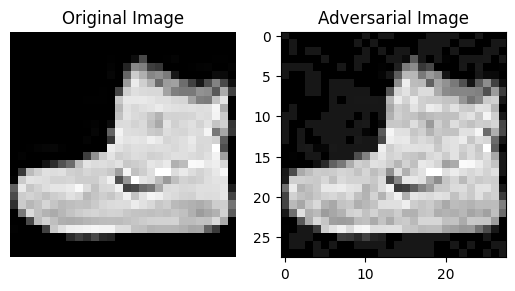

In [55]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(x_train[0].reshape(28, 28), cmap="gray")
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(x_train_adv[0].reshape(28, 28), cmap="gray")
axs[1].set_title("Adversarial Image")
axs[0].axis("off")

plt.show()

## Comparison with PERMANOVA

p-value is less than 0.05: null is rejected.

In [82]:
with torch.no_grad():
    train_adv_emb = embedder(torch.from_numpy(x_train_adv).to(device))

train_adv_emb = train_adv_emb.view(train_adv_emb.shape[0], -1)

In [83]:
sampler = PermAnovaSampler(train_adv_emb)
train_adv_emb_sampled = sampler.get_representative_sample(tot_permutations=100)

100%|██████████| 100/100 [02:19<00:00,  1.39s/it]


In [85]:
permanova = LightPermAnova(train_emb_sampled, compress=False)
pvalue = permanova.run_simulation(train_adv_emb_sampled, tot_permutations=1000)
print(f"p-value: {round(pvalue.item(),5)}")

100%|██████████| 1000/1000 [07:43<00:00,  2.16it/s]


p-value: 0.001
